## A study of the NATICUSdroid dataset

*By Augustin GRUNEWALD & Nils FALCOZ*

We invite you to see the introduction comments about the dataset in the ReadME.


## Loading modules and the dataset

In [11]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 

In [3]:
# Dataset
original_df = pd.read_csv("data/data.csv", delimiter=",")

## Exploring the dataset

In [4]:
# Basic information (shape, ...)
print(f"Dataset shape : {original_df.shape}")
print(f"Number features : {original_df.shape[1]}")
print(f"Number sample : {original_df.shape[0]}")
original_df.info()

Dataset shape : (29332, 87)
Number features : 87
Number sample : 29332
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29332 entries, 0 to 29331
Data columns (total 87 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   android.permission.GET_ACCOUNTS                                                29332 non-null  int64
 1   com.sonyericsson.home.permission.BROADCAST_BADGE                               29332 non-null  int64
 2   android.permission.READ_PROFILE                                                29332 non-null  int64
 3   android.permission.MANAGE_ACCOUNTS                                             29332 non-null  int64
 4   android.permission.WRITE_SYNC_SETTINGS                                         29332 non-null  int64
 5   android.permission.READ_EXTERNAL_STORAGE                                 

In [5]:
# Showing a bit of the dataset
original_df.head()

,android.permission.GET_ACCOUNTS,com.sonyericsson.home.permission.BROADCAST_BADGE,android.permission.READ_PROFILE,android.permission.MANAGE_ACCOUNTS,android.permission.WRITE_SYNC_SETTINGS,android.permission.READ_EXTERNAL_STORAGE,android.permission.RECEIVE_SMS,com.android.launcher.permission.READ_SETTINGS,android.permission.WRITE_SETTINGS,com.google.android.providers.gsf.permission.READ_GSERVICES,...,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.sec.android.iap.permission.BILLING,com.htc.launcher.permission.UPDATE_SHORTCUT,com.sec.android.provider.badge.permission.WRITE,android.permission.ACCESS_NETWORK_STATE,com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE,com.huawei.android.launcher.permission.READ_SETTINGS,android.permission.READ_SMS,android.permission.PROCESS_INCOMING_CALLS,Result
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [6]:
# Checking for missing values - should find non missing values
print(f"All values are non missing : {np.all(original_df.isna() == False)}")

# Checking the nature of data - all values should be int64
print(f"All values are int64 : {np.all(original_df.dtypes == np.int64)}")

# Checking that all values are 0 or 1 - adding two df of booleans with method .add
print(f"All values are 0 or 1 : {np.all((original_df == 0).add(original_df == 1))}")

All values are non missing : True
All values are int64 : True
All values are 0 or 1 : True


In [7]:
# Checking the number of benign (result = 0) and malware (result = 1) apps
benign_df = original_df[original_df["Result"] == 0]
malware_df = original_df[original_df["Result"] == 1]
print(f"Benign data shape : {benign_df.shape}")
print(f"Malware data shape : {malware_df.shape}")

Benign data shape : (14632, 87)
Malware data shape : (14700, 87)


Good to have about the same amount of data for each case : benign and malware.

In [8]:
# Looking only at the native permission requests - starting with keyword android.permission or com.android
native_columns = np.array([[i, label] for i, label in enumerate(original_df.columns) if ("android.permission" in label) or ("com.android" in label)])
non_native_columns = np.array([[i, label] for i, label in enumerate(original_df.columns) if ("android.permission" not in label) and ("com.android" not in label)])

native_permissions_df = (original_df.copy()).drop(list(non_native_columns[:,1]), axis=1)

print(f"Native permission requests dataset shape : {native_permissions_df.shape}")
print(f"Naticus (native + custom) permission requests dataset shape : {original_df.shape}")

Native permission requests dataset shape : (29332, 64)
Naticus (native + custom) permission requests dataset shape : (29332, 87)


Don't use these df after, they don't have the result column

## Unsupervised learning - Searching for important features - PCA 

Index(['android.permission.READ_PHONE_STATE', 'Result',
       'android.permission.ACCESS_COARSE_LOCATION',
       'android.permission.ACCESS_FINE_LOCATION',
       'android.permission.RECEIVE_BOOT_COMPLETED'],
      dtype='object')
Index(['android.permission.ACCESS_COARSE_LOCATION',
       'android.permission.ACCESS_FINE_LOCATION',
       'android.permission.READ_PHONE_STATE',
       'android.permission.RECEIVE_BOOT_COMPLETED',
       'android.permission.WRITE_EXTERNAL_STORAGE'],
      dtype='object')


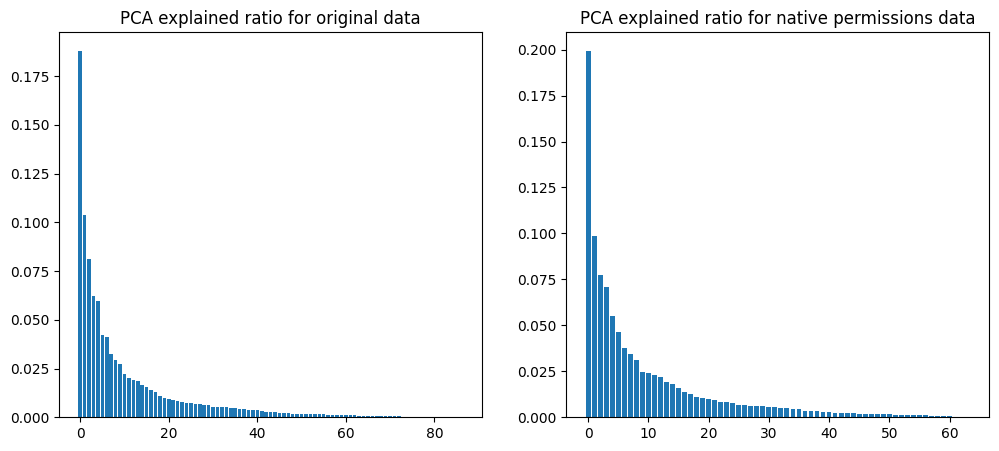

In [42]:
from sklearn.decomposition import PCA

# Computing PCA
pca_original = PCA()
pca_original.fit(original_df)

pca_native = PCA()
pca_native.fit(native_permissions_df)

# Showing the 5 most important permissions for the first PCA vector
first_component_normalized = np.abs(pca_original.components_[0])
max_importance_features = np.arange(original_df.shape[1])[np.argsort(first_component_normalized)[::-1][:5]]
print(original_df.columns[max_importance_features])

first_component_normalized_native = np.abs(pca_native.components_[0])
max_importance_features = np.arange(native_permissions_df.shape[1])[np.argsort(first_component_normalized_native)[::-1][:5]]
print(native_permissions_df.columns[max_importance_features])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes.flatten()

axes[0].bar(range(original_df.shape[1]), pca_original.explained_variance_ratio_)
axes[0].set_title("PCA explained ratio for original data")

axes[1].bar(range(native_permissions_df.shape[1]), pca_native.explained_variance_ratio_)
axes[1].set_title("PCA explained ratio for native permissions data");

In each cases (only native permissions on one side, and all permissions on the other side), we don't observe really important features, only one with about 20% of explained variance ratio and some other with about 10%. This doesn't shows a clear trend, however using the composition of the first vectors of the PCA, we can have a look at the permissions requests with most impact. => non c'est faux mdr

Most asked permissions in the dataset : Index(['android.permission.INTERNET',
       'android.permission.ACCESS_NETWORK_STATE',
       'android.permission.WRITE_EXTERNAL_STORAGE',
       'android.permission.READ_PHONE_STATE',
       'android.permission.ACCESS_WIFI_STATE'],
      dtype='object')


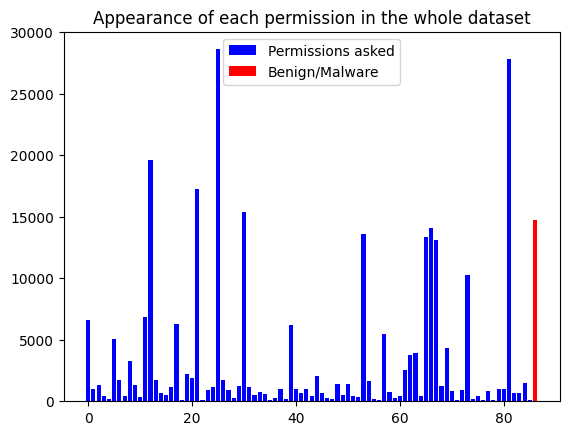

In [53]:
# Looking at the appearance of each permissions by counting them (binary data)
row_count = original_df.sum()

# The most asked permissions
first_five_ind = np.argsort(row_count[:-1])[::-1][:5]
print(f"Most asked permissions in the dataset : {original_df.columns[first_five_ind]}")

# Plotting
plt.title("Appearance of each permission in the whole dataset")
plt.bar(range(original_df.shape[1] - 1), row_count[:-1], color="blue", label="Permissions asked")
plt.bar(original_df.shape[1] - 1, row_count[-1], color="red", label="Benign/Malware")
plt.legend();

In [56]:
# Same job but distinguishing benign and malware
benign_row_count = benign_df.drop("Result", axis=1).sum()
malware_row_count = malware_df.drop("Result", axis=1).sum()

# The most asked permissions
benign_first_five_ind = np.argsort(benign_row_count)[::-1][:5]
malware_first_five_ind = np.argsort(malware_row_count)[::-1][:5]

print(f"Most asked permissions in benign apps : {original_df.columns[benign_first_five_ind]}")
print(f"Most asked permissions in malware : {original_df.columns[malware_first_five_ind]}")

Most asked permissions in benign apps : Index(['android.permission.INTERNET',
       'android.permission.ACCESS_NETWORK_STATE',
       'android.permission.WRITE_EXTERNAL_STORAGE',
       'android.permission.WAKE_LOCK', 'android.permission.ACCESS_WIFI_STATE'],
      dtype='object')
Most asked permissions in malware : Index(['android.permission.INTERNET',
       'android.permission.ACCESS_NETWORK_STATE',
       'android.permission.READ_PHONE_STATE',
       'android.permission.WRITE_EXTERNAL_STORAGE',
       'android.permission.RECEIVE_BOOT_COMPLETED'],
      dtype='object')


#### REMOVING MOST INSIGNIFIANT PERMISSIONS REQUESTS ?


## Unsupervised learning - Trying to cluster the benign/malware - KMeans 

True positive : 10981/14700 = 74.70%
True negative : 11500/14632 = 78.59%
False negative (type 2) : 3719/14700 = 25.30%
False positive (type 1) : 3132/14632 = 21.41%


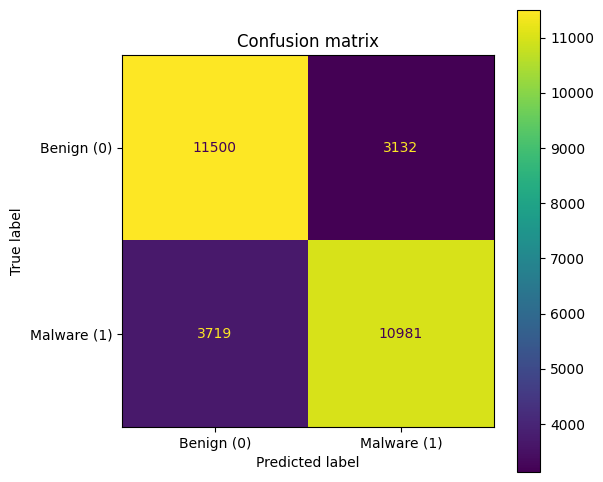

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dropping the last columns with the classification benign/malware
original_df_no_result = original_df.drop("Result", axis=1)

# Clustering in the original space
kmeans_original = KMeans(n_clusters=2)
kmeans_original.fit(original_df_no_result)
y_pred_original = kmeans_original.predict(original_df_no_result)

# Looking at the predictions results - changing 0 to 1 in the prediction, to match the original one (a majority of 0 should match the 0 original label)
expected_result_original = original_df["Result"].to_numpy()
comparison = y_pred_original == expected_result_original
# If less than half of the data are correctly assigned, change 0 to 1 in the prediction
if comparison.sum() <= len(expected_result_original)//2:
    y_pred_original = np.where(y_pred_original == 0, 1, 0) 

# Confusion matrix
cm = confusion_matrix(expected_result_original, y_pred_original, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Benign (0)', 'Malware (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
ax.set_title("Confusion matrix");

# Proportions 
print(f"True positive : {cm[1,1]}/{cm[1,0] + cm[1,1]} = {100 * cm[1,1]/(cm[1,0] + cm[1,1]):.2f}%")
print(f"True negative : {cm[0,0]}/{cm[0,0] + cm[0,1]} = {100 * cm[0,0]/(cm[0,0] + cm[0,1]):.2f}%")
print(f"False negative (type 2) : {cm[1,0]}/{cm[1,0] + cm[1,1]} = {100 * cm[1,0]/(cm[1,0] + cm[1,1]):.2f}%")
print(f"False positive (type 1) : {cm[0,1]}/{cm[0,0] + cm[0,1]} = {100 * cm[0,1]/(cm[0,0] + cm[0,1]):.2f}%")

We take a look at the impact of the topography of the initial space, does it enable an easy clustering and if so, we could then imagine to possibly go further with SVM for example in order to accept new data.

## Supervised learning 

In [119]:
from sklearn.utils import shuffle

# Splitting data from label
X = original_df.drop("Result", axis=1).to_numpy()
y = original_df["Result"].to_numpy()

# Splitting in 70/30 training & testing - we wish to have approximately 50% of malware and benign apps in the training and testing set for better performances
threshold = int(original_df.shape[0] * 0.7)
inds = np.array(shuffle(range(X.shape[0]), random_state=42))

X_train = X[inds[:threshold]]
y_train = y[inds[:threshold]]
X_test = X[inds[threshold:]]
y_test = y[inds[threshold:]]

# Checking we've about half malware/benign in training and testing dataset
print(f"Training dataset : malware = {y_train.sum()} / benign = {len(y_train) - y_train.sum()} -> {100 * y_train.sum() / len(y_train):.2f}% & {100 - 100 * y_train.sum() / len(y_train):.2f}%")
print(f"Testing dataset : malware = {y_test.sum()} / benign = {len(y_test) - y_test.sum()} -> {100 * y_test.sum() / len(y_test):.2f}% & {100 - 100 * y_test.sum() / len(y_test):.2f}%")

Training dataset : malware = 10266 / benign = 10266 -> 50.00% & 50.00%
Testing dataset : malware = 4434 / benign = 4366 -> 50.39% & 49.61%


## SVM

True positive : 4281/4434 = 96.55%
True negative : 4203/4366 = 96.27%
False negative (type 2) : 153/4434 = 3.45%
False positive (type 1) : 163/4366 = 3.73%


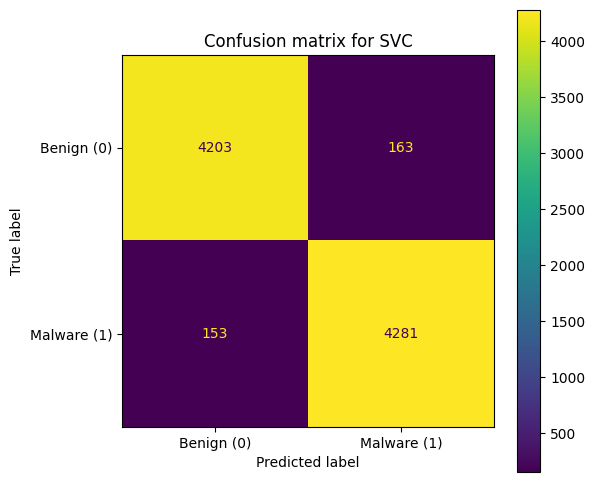

In [124]:
from sklearn.svm import SVC

# Computing svc
svc_original = SVC(kernel="rbf", C=1.) # We keep a low C value in order to have better generalization 
svc_original.fit(X_train, y_train)
y_pred = svc_original.predict(X_test)

# Confusion matrix
cm_svc = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Benign (0)', 'Malware (1)'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
ax.set_title("Confusion matrix for SVC");

# Proportions 
print(f"True positive : {cm_svc[1,1]}/{cm_svc[1,0] + cm_svc[1,1]} = {100 * cm_svc[1,1]/(cm_svc[1,0] + cm_svc[1,1]):.2f}%")
print(f"True negative : {cm_svc[0,0]}/{cm_svc[0,0] + cm_svc[0,1]} = {100 * cm_svc[0,0]/(cm_svc[0,0] + cm_svc[0,1]):.2f}%")
print(f"False negative (type 2) : {cm_svc[1,0]}/{cm_svc[1,0] + cm_svc[1,1]} = {100 * cm_svc[1,0]/(cm_svc[1,0] + cm_svc[1,1]):.2f}%")
print(f"False positive (type 1) : {cm_svc[0,1]}/{cm_svc[0,0] + cm_svc[0,1]} = {100 * cm_svc[0,1]/(cm_svc[0,0] + cm_svc[0,1]):.2f}%")


In [128]:
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.metrics import recall_score, accuracy_score

# Fine tunning of the C parameter
param_grid = {'C': np.logspace(-3, 2, 6)}

# We keep the accuracy -> (TP+TN)/(TP+TN+FN+FP) and the recall -> TP/(TP+FN)
scoring_metrics = ['accuracy', 'recall']

# Kfold in order to have better results with SVC (10 splits according to the recommendations)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Base model initialization
base_svc = SVC(kernel="rbf", random_state=42)

# Using GridSearchCV
grid_search = GridSearchCV(
    estimator=base_svc,                                      # Base model 
    param_grid=param_grid,                                   # Search hyperparameters space
    scoring=scoring_metrics,                                 # Used metrics
    refit='recall',                                          # Best model is chosen using 'recall'
    cv=KFold(n_splits=10, shuffle=True, random_state=42),    # Using 10 split KFold 
    verbose=2,                                               # Showing progression
    n_jobs=-1                                                # Parallelization : Using all cores
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ............................................C=0.001; total time=  37.1s
[CV] END ............................................C=0.001; total time=  37.1s
[CV] END ............................................C=0.001; total time=  37.2s
[CV] END ............................................C=0.001; total time=  37.8s
[CV] END ............................................C=0.001; total time=  47.7s
[CV] END ............................................C=0.001; total time=  48.3s
[CV] END ............................................C=0.001; total time=  48.5s
[CV] END ............................................C=0.001; total time=  48.6s
[CV] END .............................................C=0.01; total time=  15.5s
[CV] END .............................................C=0.01; total time=  15.7s
[CV] END .............................................C=0.01; total time=  16.8s
[CV] END .......................................

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             refit='recall', scoring=['accuracy', 'recall'], verbose=2)

In [130]:
# Getting all results from the GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Looking for the best model parameters
best_C = grid_search.best_params_['C']
best_recall_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

print(f"Best C value : {best_C}")
print(f"Best Recall associated: {best_recall_score:.4f}")

# Global results
print("\nMeans of the KFold for each C value :")
print(results[['param_C', 'mean_test_accuracy', 'mean_test_recall']])

Best C value : 1.0
Best Recall associated: 0.9668

Means of the KFold for each C value :
  param_C  mean_test_accuracy  mean_test_recall
0   0.001            0.879310          0.914320
1    0.01            0.946912          0.962715
2     0.1            0.959770          0.966823
3     1.0            0.966053          0.966834
4    10.0            0.968780          0.963043
5   100.0            0.967611          0.960801
